In [1]:
import numpy as np
import torch.nn as nn
from s2cnn import SO3Convolution
from s2cnn import S2Convolution
from s2cnn import so3_integrate
from s2cnn import so3_near_identity_grid
from s2cnn import s2_near_identity_grid
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
import argparse
import os

In [2]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
import matplotlib.pyplot as plt

In [3]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv')
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv')
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def load_data(data_lpmt, true_info, batch_size):
    ys = true_info
    mask = (ys.R <= MAXR)
    data_lpmt = data_lpmt[mask]
    y_val = ys[mask][['E']].values
    
    train_data = torch.from_numpy(data_lpmt.transpose([0,3,1,2]))
    train_labels = torch.from_numpy(y_val)

    train_dataset = data_utils.TensorDataset(train_data, train_labels)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, train_dataset

In [7]:
class S2ConvNet_deep(nn.Module):

    def __init__(self, bandwidth=30):
        super(S2ConvNet_deep, self).__init__()

        grid_s2    =  s2_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1)
        grid_so3_1 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_2 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 8, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_3 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 4, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_4 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 2, n_beta=1, max_gamma=2*np.pi, n_gamma=6)

        self.convolutional = nn.Sequential(
            S2Convolution(
                nfeature_in  = 2,
                nfeature_out = 8,
                b_in  = bandwidth,
                b_out = bandwidth,
                grid=grid_s2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  =  8,
                nfeature_out = 16,
                b_in  = bandwidth,
                b_out = bandwidth//2,
                grid=grid_so3_1),
            nn.ReLU(inplace=False),

            SO3Convolution(
                nfeature_in  = 16,
                nfeature_out = 32,
                b_in  = bandwidth//2,
                b_out = bandwidth//2,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 32,
                nfeature_out = 64,
                b_in  = bandwidth//2,
                b_out = bandwidth//4,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),
            )

        self.linear = nn.Sequential(
            # linear 1
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64,out_features=256),
            nn.ReLU(inplace=False),
            # linear 2
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(inplace=False),
            # linear 3
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = so3_integrate(x)
        x = self.linear(x)
        return x

In [8]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [9]:
rg = np.arange(0,100000,15000)
MAXR = 17200

In [10]:
data_lpmt =np.load(LTRAIN + '1_' + str(0) +'without_noise_time_min_xu_stereo'+ '.npy')

In [11]:
true_info = tr_true_info[(tr_true_info['evtID'] >= rg[0]) 
                            & (tr_true_info['evtID'] < rg[1])]

In [12]:
train_loader, train_dataset = load_data(data_lpmt, true_info, 15)

In [13]:
data_lpmt.shape

(15000, 110, 110, 2)

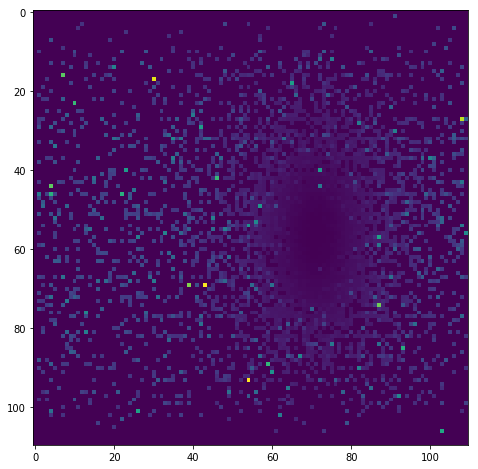

In [14]:
fig = plt.figure(figsize=(10,8))
plt.imshow(data_lpmt[0][:,:,1])

In [15]:
model = S2ConvNet_deep(bandwidth=55)

In [16]:
criterion = nn.MSELoss()
criterion = criterion.to(DEVICE)

In [17]:
model.to(DEVICE)

S2ConvNet_deep(
  (convolutional): Sequential(
    (0): S2Convolution()
    (1): ReLU()
    (2): SO3Convolution()
    (3): ReLU()
    (4): SO3Convolution()
    (5): ReLU()
    (6): SO3Convolution()
    (7): ReLU()
  )
  (linear): Sequential(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [18]:
optimizer = torch.optim.Adam(
        model.parameters())

In [20]:
losses = []

In [22]:
from tqdm import tqdm_notebook

In [ ]:
for epoch in range(10):
    for i, (images, labels) in tqdm_notebook(enumerate(train_loader)):
        model.train()
        images = images.float().to(DEVICE)
        labels = labels.float().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        l = loss.detach().cpu().numpy()
        losses.append(l)
        optimizer.step()
    print(np.mean(losses[-100:]))


0.4871462



0.63631517


(0, 0.09)

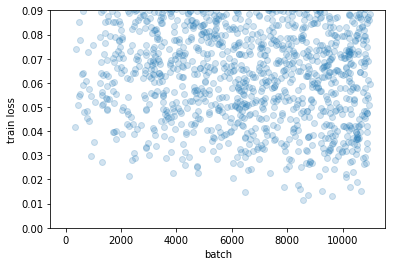

In [32]:
plt.scatter(np.arange(len(losses)), losses, alpha=0.2)
plt.xlabel("batch")
plt.ylabel("train loss")
plt.ylim((0, 0.09))